In [1]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from scipy.io import loadmat
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import create_RDM, compute_dRSA, get_device, decode_matlab_strings, print_wise, get_lagplot_subset, subsample_RDM
from image_processing.utils import get_usual_transform
#from image_processing.computational_models import map_image_order_from_ann_to_monkey
device = get_device()

15:11:32 - device being used: mps


In [2]:
from dataclasses import dataclass

@dataclass
class Cfg:
    img_size: int = 224
    model_name: str = 'vit_l_16'
    layer_name: str = 'features.7'
    monkey_name: str = 'paul' 
    date: str = '230204'
    avg_win: int = 10 #ms
    pkg: str = 'torchvision'
    similarity_metric: str = "cosine"
cfg = Cfg()
from general_utils.utils import get_relevant_output_layers
layers = get_relevant_output_layers(cfg.model_name, pkg=cfg.pkg)

In [ ]:
monkey_name = "paul"
date = "230204"
allimgs_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_allimages{cfg.date}.mat"
rasters_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_natraster{cfg.date}.mat"
with h5py.File(allimgs_path, "r") as f:
    try:
        refs = f["allimages"][:]      # shape (N, 1) of object refs
    except KeyError:
        refs = f["uniqueImage"][:]
    # end try
    image_names = decode_matlab_strings(f, refs)
    image_names = sorted(set(image_names)) 
# from scipy.io import loadmat
# loadmat(allimgs_path)

In [4]:
with h5py.File(rasters_path, "r") as f:
    rasters = f["natraster"][:]      
rasters = rasters.transpose(2, 1, 0)
print(rasters.shape) # channels, time, trials

(383, 400, 4377)


In [168]:
from data_preprocessing.preprocessing import create_bins, get_firing_rate
bins = create_bins(400, cfg.avg_win)
#neural_signal = rasters[trial_start_int - foreperiod_len:trial_end_int, :].T  # slices the trial from raster
tot_firing_rate = []
for i_trial in range(rasters.shape[2]):
    firing_rate = get_firing_rate(bins, rasters[:,:,i_trial])
    tot_firing_rate.append(firing_rate)


In [169]:
rasters_smooth = np.stack(tot_firing_rate, axis=2)

In [170]:
RDMs_list =[]
for i_time in range(rasters_smooth.shape[1]):
    RDMs_list.append(create_RDM(rasters_smooth[:20, i_time, :], metric="cosine"))

In [441]:
idx = np.random.randint(low=0, high=rasters_smooth.shape[2], size=1000)

KeyboardInterrupt: 

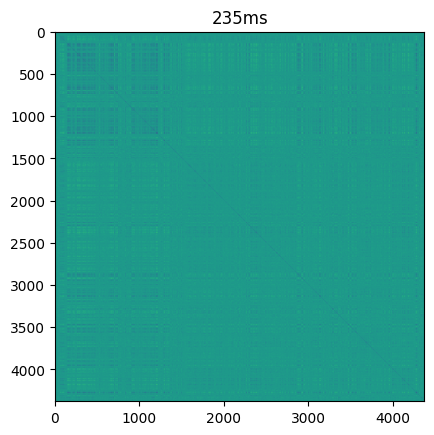

In [107]:
from IPython.display import clear_output

for i_time in range(len(RDMs_list)):
    plt.imshow(squareform(RDMs_list[i_time]))
    plt.title(f"{i_time*cfg.avg_win}ms")
    plt.pause(0.001)
    plt.close() 
    clear_output(wait=True)

In [442]:
RDM_mod = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}_RDM.npz")["arr_0"]
feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}_features.npz")["arr_0"]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tizianocausin/livingstone_lab_local/tiziano/models/paul_230204_vit_l_16_224_features.7_RDM.npz'

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


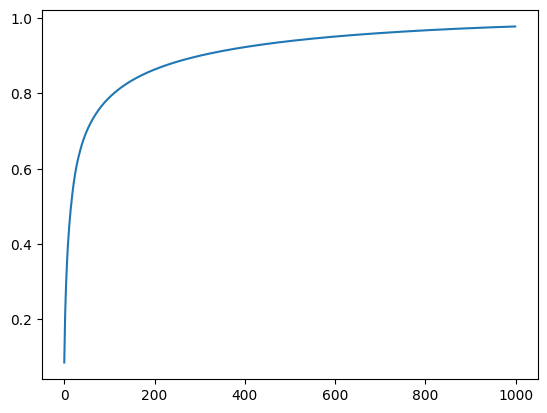

In [11]:
import joblib
pca = joblib.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{layers[-1]}_1000PCs.pkl")
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [423]:
RDM_mod_ord = subsample_RDM(squareform(RDM_mod), mapping_idx)
print(RDM_mod_ord.shape)

(4377, 4377)


In [44]:
feats.shape

(4377, 64)

In [50]:
f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz"

'/Users/tizianocausin/livingstone_lab_local/tiziano/models/paul_230204_vit_l_16_224_blocks.23.mlp.fc2_features_meanpool.npz'

In [171]:
from scipy.stats import spearmanr

randidx = np.random.randint(0, len(image_names), 100)
max_latency = []
all_dRSAs = []
for l in layers[:]:
    print_wise(f"computing layer {l}")
    similarity = []
    try:
        #RDM_mod = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_RDM_meanpool.npz")["arr_0"]
        feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]
        # feats = feats[:,randidx]
        RDM_mod = create_RDM(feats.T, metric="cosine")
        #RDM_mod_ord = subsample_RDM(squareform(RDM_mod), mapping_idx)
        # RDM_mod = squareform(subsample_RDM(squareform(RDM_mod), randidx))
        for i_time in range(len(RDMs_list)):
            #RDM_neu = squareform(subsample_RDM(squareform(RDMs_list[i_time]), randidx))
            RDM_neu = RDMs_list[i_time]
            similarity.append(np.corrcoef(RDM_neu, RDM_mod)[0, 1])
        all_dRSAs.append(similarity)
        max_latency.append(np.argmax(similarity))
        # plt.plot(similarity, label=f"{l} - {max_latency[-1]*cfg.avg_win}")
    except FileNotFoundError:
        print_wise(f"{l} not found")
# plt.legend()
max_latency = np.array(max_latency)*cfg.avg_win

11:17:27 - computing layer features.0
11:17:29 - computing layer features.4
11:17:32 - computing layer features.7
11:17:36 - computing layer features.9
11:17:39 - computing layer features.11
11:17:42 - computing layer classifier.2
11:18:16 - computing layer classifier.5


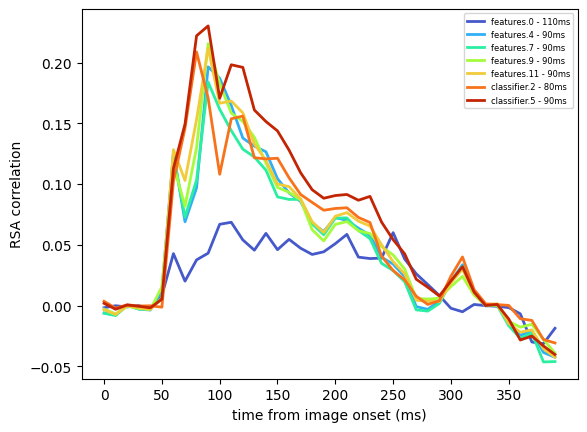

In [172]:
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name})",
        cmap(np.linspace(minval, maxval, n))
    )

base_cmap = plt.cm.turbo
cmap = truncate_colormap(base_cmap, 0.10, 0.90)


fig, ax = plt.subplots()
for idx, dRSA in enumerate(all_dRSAs):
    color = cmap(idx / (len(layers) - 1))
    ax.plot(dRSA, label=f"{layers[idx]} - {max_latency[idx]}ms", color=color,  linewidth=2)
ax.legend(fontsize=6)
ax.set_ylabel("RSA correlation")
ax.set_xlabel("time from image onset (ms)")
ax.set_xticks(np.arange(0, len(all_dRSAs[0]), 50//cfg.avg_win));
ax.set_xticklabels(np.arange(0, len(all_dRSAs[0]), 50//cfg.avg_win)*cfg.avg_win);



In [175]:
from image_processing.utils import load_torchvision_model, load_timm_model
from general_utils.utils import get_layer_output_shape
from torchvision.models.feature_extraction import get_graph_node_names
device = get_device()
m = load_timm_model(cfg.model_name, device) if cfg.pkg == 'timm' else load_torchvision_model(cfg.model_name, device)
all_layers = get_graph_node_names(m)
layers_depth = np.array([all_layers[0].index(l)/len(all_layers[0]) for l in layers])



11:20:22 - device being used: mps


Text(0.01, 0.99, 'pearson = -0.705\nspearman = -0.107')

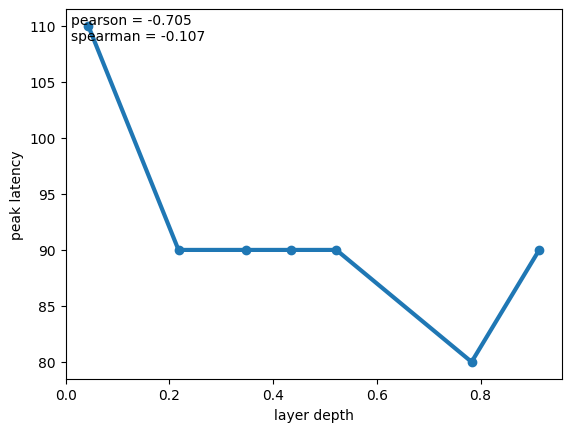

In [176]:
from general_utils.utils import spearman
pearson = np.corrcoef(layers_depth, max_latency)[0,1]
spearman = spearman(np.array(layers_depth), max_latency)
fig, ax = plt.subplots()
ax.plot(layers_depth, max_latency, marker="o", linewidth=3)
ax.set_ylabel("peak latency")
ax.set_xlabel("layer depth")
# Fix: combine your text strings into one
ax.text(0.01, 0.99, f"pearson = {pearson:.3f}\nspearman = {spearman:.3f}", 
        transform=ax.transAxes, 
        verticalalignment='top', 
        horizontalalignment='left')


In [ ]:
from image_processing.utils import load_torchvision_model, load_timm_model
from general_utils.utils import get_layer_output_shape
from torchvision.models.feature_extraction import create_feature_extractor
device = get_device()
vit = load_timm_model("vit_l_16", device)
alexnet = load_torchvision_model("alexnet", device)

08:49:39 - device being used: mps


In [78]:
def gget_layer_output_shape(feature_extractor, layer_name, imsize=224):
    device = get_device() 
    with torch.no_grad():
        in_proxy = torch.randn(1, 3, imsize, imsize).to(device)
        tmp_shape = feature_extractor(in_proxy)[layer_name].shape[:]
    return tmp_shape
# EOF
#vit_fe = create_feature_extractor(vit, return_nodes=[layers[0]])
alexnet_fe = create_feature_extractor(alexnet, return_nodes=["features.0"])
print(gget_layer_output_shape(alexnet_fe, "features.0", imsize=224) ) # gget_layer_output_shape(vit_fe, layers[0], imsize=384),

15:36:53 - device being used: mps
torch.Size([1, 64, 55, 55])


In [50]:
get_relevant_output_layers("alexnet")

['features.0',
 'features.4',
 'features.7',
 'features.9',
 'features.11',
 'classifier.2',
 'classifier.5']

In [412]:
allimgs_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_allimages{cfg.date}.mat"
with h5py.File(allimgs_path, "r") as f:
    try:
        refs = f["allimages"][:]      # shape (N, 1) of object refs
    except KeyError:
        refs = f["uniqueImage"][:]
    # end try
    image_names = decode_matlab_strings(f, refs)
    image_names_unique = list(dict.fromkeys(image_names)) 
# from scipy.io import loadmat
# loadmat(allimgs_path)

In [418]:
image_names[:30]

['pman_4_half.jpg',
 'mface_1_hair.jpg',
 'FH_176.jpg',
 'Sony_Bravia_cellphone_1.jpg',
 'jumblefaces_06.jpg',
 'BigAnimate_39.jpg',
 'rock_015.jpg',
 'breadloaf_14.jpg',
 'OtherGuy_2_wbkg.jpg',
 'pezdispenser_002.jpg',
 'mface_5_100white.jpg',
 'object_6_bars.jpg',
 'mface_7_100white.jpg',
 'red_3_barless.jpg',
 'bonzai_14.jpg',
 'pface_2_tiny.jpg',
 'mface_4_bkg_bars.jpg',
 'hface_10_hair.jpg',
 'trumpet33.jpg',
 'musicstand_003.jpg',
 'Alei22.jpg',
 'FFM_046.jpg',
 'FH_66.jpg',
 'FFM_165.jpg',
 'dts_8.jpg',
 'FH_7.jpg',
 'pie_003.jpg',
 'cooler_015.jpg',
 'UFH_187.jpg',
 'tennisracquet_04.jpg']

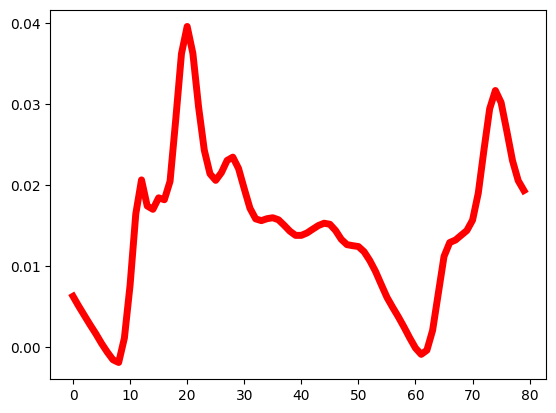

In [342]:
plt.plot(np.mean(rasters_smooth, axis=(0,2))*.1, color="red", linewidth=5)

In [140]:
dRSA = compute_dRSA(rasters_smooth[:20, :50, :1000],rasters_smooth[300:330, :50, :1000])

Text(0.5, 1.0, 'V1 -> probe tip')

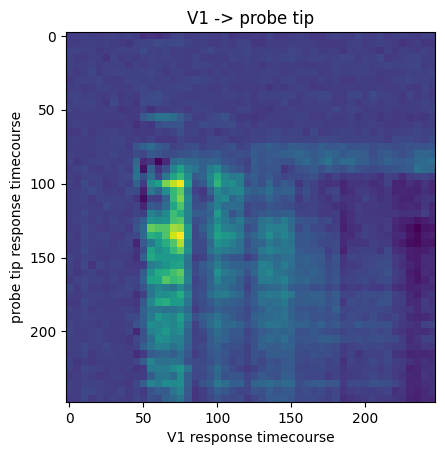

In [241]:
fig, ax = plt.subplots()
ax.imshow(dRSA)
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_xticklabels(np.array([0, 10, 20, 30, 40])*cfg.avg_win)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(np.array([0, 10, 20, 30, 40])*cfg.avg_win)
ax.set_ylabel("probe tip response timecourse")
ax.set_xlabel("V1 response timecourse")
ax.set_title("V1 -> probe tip")

In [235]:
np.arange(-20, 21, 5)

array([-20, -15, -10,  -5,   0,   5,  10,  15,  20])

35 ms


Text(0.5, 1.0, 'V1 -> probe tip')

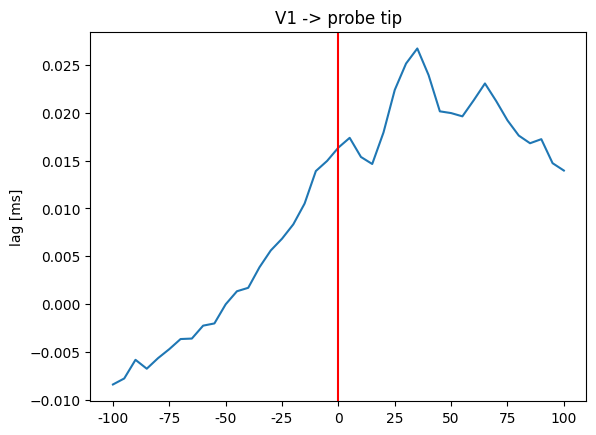

In [242]:
lp = get_lagplot_subset(dRSA, np.arange(20, 40))
fig, ax = plt.subplots()
print((np.argmax(lp) - 20)*5, "ms")
ax.plot(lp)
ax.axvline(20, color='red')
ax.set_xticks(np.arange(0, 41, 5))
ax.set_xticklabels(np.arange(-20, 21, 5)*cfg.avg_win)
ax.set_ylabel("similarity (corr)")
ax.set_ylabel("lag [ms]")
ax.set_title("V1 -> probe tip")

 compute linear regression (with the dimensionality reduced features) and check the fit over time

In [35]:
from general_utils.regression import choose_CV_type, choose_regression_type, evaluate_prediction
def lagged_img_linear_regression(x, y, regression_type='lr', alpha=0.0, cv_type='same', n_splits=5, shuffle=True, max_lag=20, symmetric=False):
    lr_list = []
    if symmetric:
        lags_range = range(max_lag+1)
    else:
        lags_range = range(-max_lag, max_lag+1)
    # end if symmetric:

    x_shifted_tot = x.T
    for tau in range(y.shape[1]):
        y_shifted_tot = y[:,tau,:].T
        CV = choose_CV_type(cv_type, n_splits=n_splits, shuffle=shuffle)
        curr_lr = []
        for train_idx, test_idx in CV.split(x_shifted_tot):
            train_x, train_y = x_shifted_tot[train_idx, :], y_shifted_tot[train_idx, :]
            test_x, test_y = x_shifted_tot[test_idx, :], y_shifted_tot[test_idx, :]
            regression_obj = choose_regression_type(regression_type=regression_type, alpha=alpha)
            regression_obj = regression_obj.fit(train_x, train_y)
            #R2 = regression_obj.score(test_x, test_y) # later add correlation and see if add weights or something else
            avg_corr = evaluate_prediction(test_x, test_y, regression_obj)
            curr_lr.append(avg_corr)
        # end for train_idx, test_idx in CV.split(x_shifted_tot):
        lr_list.append(np.nanmean(curr_lr))  #x_t_shifted_tot, y_t_shifted_tot))
    # end for L in range(-max_lag, max_lag):    
    return lr_list
# EOF




In [177]:

lr_list = []
computed_layers_list = []
for l in layers:
    print_wise(l)
    try:
        feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]
        lr = lagged_img_linear_regression(feats[:, :], rasters_smooth[:20,:,:], regression_type="ridge", alpha=1, cv_type="kf")
        lr_list.append(lr)
        computed_layers_list.append(l)
    except FileNotFoundError:
        print_wise(f"{l} not found")
        pass
max_latency_lr = np.array([np.argmax(lr) for lr in lr_list])*cfg.avg_win

11:21:24 - features.0
11:21:24 - features.4
11:21:26 - features.7
11:21:29 - features.9
11:21:30 - features.11
11:21:32 - classifier.2


/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.26834e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.19824e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.86604e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.05207e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Des

11:22:52 - classifier.5


/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.1462e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.08289e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.88402e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.0229e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tizianocausin/Deskt

Text(0.5, 1.0, 'lagged linear regression')

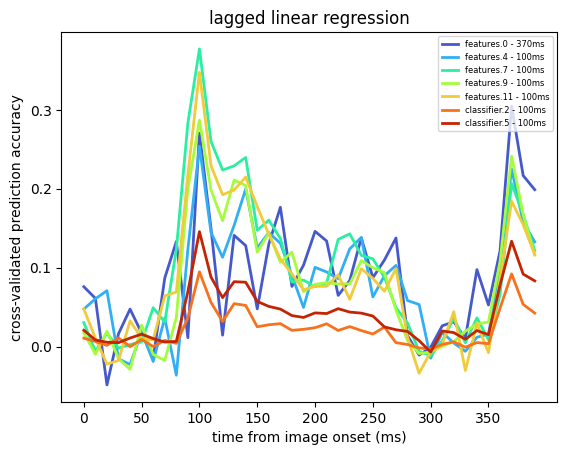

In [178]:
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name})",
        cmap(np.linspace(minval, maxval, n))
    )

base_cmap = plt.cm.turbo
cmap = truncate_colormap(base_cmap, 0.10, 0.90)


fig, ax = plt.subplots()
for idx, dRSA in enumerate(lr_list):
    color = cmap(idx / (len(layers) - 1))
    ax.plot(dRSA, label=f"{layers[idx]} - {max_latency_lr[idx]}ms", color=color,  linewidth=2)
ax.legend(fontsize=6, loc="upper right")
ax.set_ylabel("cross-validated prediction accuracy")
ax.set_xlabel("time from image onset (ms)")
ax.set_xticks(np.arange(0, len(all_dRSAs[0]), 50//cfg.avg_win));
ax.set_xticklabels(np.arange(0, len(lr_list[0]), 50//cfg.avg_win)*cfg.avg_win);
ax.set_title("lagged linear regression")

In [ ]:

pearson = np.corrcoef(layers_depth, max_latency_lr)[0,1]
spearman = spearman(np.array(layers_depth), max_latency_lr)
fig, ax = plt.subplots()
ax.plot(layers_depth, np.array(max_latency_lr)*cfg.avg_win, marker="o", linewidth=3)

# Fix: combine your text strings into one
ax.text(0.01, 0.99, f"pearson = {pearson:.3f}\nspearman = {spearman:.3f}", 
        transform=ax.transAxes, 
        verticalalignment='top', 
        horizontalalignment='left')

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TypeError: 'numpy.float64' object is not callable

In [270]:
import joblib
feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}_features.npz")["arr_0"]
pca = joblib.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}_1000PCs.pkl")

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [271]:
evecs = pca.components_

In [272]:
mapping_idx = [2726, 2430, 1089, 784, 1779, 38, 3597, 693, 1969, 3438, 3118, 3266, 3132, 2097, 660, 2650, 3114, 2261, 3908, 2161, 1851, 109, 1236, 228, 2829, 1241, 3446, 891, 4241, 3797, 1854, 3270, 3167, 4224, 2538, 1183, 1385, 4060, 721, 2351, 2876, 3906, 344, 1902, 1253, 4279, 968, 1696, 2197, 1799, 200, 1942, 753, 2756, 623, 2865, 3717, 1360, 3513, 786, 2959, 1633, 3482, 2655, 363, 3144, 419, 898, 2277, 120, 1760, 2671, 2432, 4012, 4278, 418, 3826, 3084, 2019, 2139, 3804, 2405, 3674, 147, 3532, 3418, 2532, 1615, 1668, 856, 292, 2034, 2407, 1462, 859, 3551, 4190, 1774, 2680, 615, 1691, 4186, 373, 4073, 3341, 1050, 1059, 1338, 2579, 3440, 2200, 13, 3024, 2164, 827, 4046, 536, 1150, 69, 2580, 1827, 2205, 1108, 303, 889, 4162, 3356, 4170, 3550, 806, 1546, 2976, 2604, 254, 2021, 548, 3045, 1263, 652, 1724, 3828, 3991, 2639, 2813, 3554, 268, 3516, 2808, 943, 1871, 3466, 1808, 948, 611, 1514, 3977, 4127, 3968, 3573, 3286, 1469, 424, 462, 876, 1021, 4288, 1885, 2895, 3242, 1259, 3402, 154, 2448, 3016, 1758, 3744, 3245, 1838, 2130, 107, 3751, 3282, 59, 3510, 1043, 3680, 915, 826, 2603, 3786, 3040, 2719, 278, 493, 1323, 2106, 1443, 3560, 3468, 3382, 1081, 1795, 2422, 3355, 4157, 3775, 316, 2280, 605, 3881, 1621, 1940, 4172, 614, 543, 3602, 1627, 2962, 1393, 2046, 3053, 2363, 113, 3951, 1054, 1939, 857, 2645, 3608, 4193, 4329, 1920, 2877, 3667, 3046, 2260, 4328, 1655, 2912, 220, 2873, 1693, 2300, 1999, 4140, 2183, 2739, 3699, 2842, 270, 2355, 3644, 454, 3517, 1074, 1820, 4260, 2504, 224, 3387, 3354, 3829, 4189, 2235, 1575, 3208, 711, 3199, 1830, 1486, 186, 2409, 2190, 3590, 839, 2143, 1844, 2529, 40, 3494, 3182, 1033, 1125, 3642, 4147, 1097, 579, 3220, 2338, 3949, 2646, 498, 1810, 2886, 2162, 2386, 702, 1450, 3131, 1539, 764, 2402, 2339, 1179, 2023, 4284, 2237, 2008, 3020, 1509, 2922, 2928, 198, 1217, 914, 732, 584, 4339, 1959, 232, 3528, 2696, 2486, 4235, 1016, 2686, 3193, 229, 4056, 900, 3039, 3581, 3857, 2795, 3204, 3847, 2118, 3787, 3321, 1577, 2268, 3143, 2986, 61, 1211, 3634, 1923, 2258, 1605, 4267, 3686, 4229, 3713, 1240, 3, 1014, 1276, 1977, 616, 181, 1470, 3300, 457, 1825, 1534, 2585, 685, 1654, 2978, 2041, 678, 1673, 1585, 1948, 3104, 2427, 3766, 269, 325, 4021, 1203, 2131, 2763, 2132, 1778, 317, 128, 212, 1171, 1835, 3140, 4103, 3142, 1884, 467, 1501, 2856, 770, 1877, 2116, 2347, 1458, 1769, 2487, 1906, 1787, 4277, 231, 3081, 2305, 3762, 2963, 550, 3350, 1427, 1843, 2147, 2178, 3781, 3111, 4219, 1792, 3330, 2069, 1587, 2248, 956, 2094, 1548, 2309, 3244, 1738, 2526, 3714, 2349, 1610, 699, 494, 2651, 904, 1650, 2236, 2269, 2541, 1132, 1464, 944, 2076, 2553, 4201, 594, 2998, 2230, 1556, 3299, 1978, 4020, 2009, 4108, 3122, 1530, 1071, 78, 3710, 2081, 2475, 969, 1653, 3136, 3654, 2830, 1700, 2170, 1506, 2909, 2518, 3335, 1031, 761, 289, 4007, 3398, 1990, 1422, 4203, 383, 1358, 868, 3113, 1397, 2478, 96, 1019, 557, 3862, 4319, 2543, 4273, 3594, 3007, 2848, 1392, 1160, 2846, 2544, 1092, 1131, 1277, 664, 2308, 2944, 1167, 3315, 433, 3889, 710, 3488, 3162, 3866, 125, 39, 3812, 2786, 2674, 3071, 3639, 3696, 3472, 866, 3319, 3407, 1148, 145, 1916, 1672, 1273, 3238, 105, 1771, 2611, 1042, 759, 4228, 2752, 3453, 1436, 1099, 1833, 2641, 77, 2367, 3439, 2684, 950, 682, 1729, 1177, 152, 4239, 1488, 2251, 2994, 1494, 2590, 4101, 698, 310, 3593, 2433, 1286, 2949, 1399, 3962, 124, 1883, 1712, 1152, 4166, 2814, 1077, 3001, 519, 87, 3395, 2223, 3545, 2127, 648, 3595, 3469, 3915, 4135, 380, 2918, 2299, 3322, 3287, 3742, 4107, 1721, 386, 448, 3250, 1748, 1930, 1581, 2450, 964, 425, 2812, 3317, 2713, 4256, 997, 3943, 4171, 1328, 4192, 993, 980, 1156, 756, 1907, 3871, 1603, 436, 3128, 3974, 3872, 3670, 2462, 101, 4204, 3389, 3484, 3535, 1586, 3175, 2113, 3056, 1917, 2152, 1324, 413, 3095, 1968, 2993, 1372, 3429, 3078, 1279, 3930, 3134, 798, 2379, 2365, 162, 2177, 1692, 1667, 2485, 3792, 2940, 599, 3296, 2693, 4234, 1956, 2890, 1601, 294, 2598, 2841, 1322, 1367, 3987, 329, 621, 2634, 957, 324, 287, 1140, 2681, 705, 217, 4326, 1475, 2484, 4231, 3630, 2089, 1233, 3409, 897, 2717, 3705, 3115, 2245, 742, 5, 3069, 911, 1954, 1336, 4106, 1734, 864, 3288, 1741, 886, 3939, 3932, 3092, 178, 4164, 1540, 1457, 2973, 1381, 2811, 2800, 137, 2283, 1365, 774, 3844, 2644, 1067, 2304, 3025, 4097, 3702, 3586, 1511, 3604, 2282, 3318, 4225, 23, 4096, 487, 3684, 707, 148, 3808, 844, 1600, 409, 2115, 952, 157, 2761, 604, 223, 458, 313, 4115, 564, 3759, 3578, 1376, 2384, 1762, 2124, 4163, 4043, 4276, 1804, 2052, 4011, 428, 490, 1881, 708, 2137, 3729, 2125, 1142, 1230, 2272, 2562, 881, 3694, 401, 673, 2493, 978, 253, 867, 1135, 2850, 2755, 1576, 3125, 1306, 731, 2096, 2750, 3129, 3293, 4078, 4320, 2519, 1768, 3005, 3073, 4197, 388, 1849, 3954, 1523, 3215, 888, 354, 1334, 3059, 2704, 2397, 1100, 2979, 2385, 933, 3940, 3219, 514, 2778, 2313, 1574, 4185, 1751, 308, 117, 3214, 1803, 315, 3800, 2637, 4064, 1991, 161, 3275, 2508, 3656, 961, 1291, 3151, 893, 657, 3905, 1878, 4208, 773, 4213, 2265, 4210, 4264, 281, 3556, 3014, 3120, 2591, 290, 1164, 571, 3985, 2403, 3711, 1083, 2463, 3252, 675, 1806, 2160, 2892, 3022, 697, 3380, 1676, 299, 3202, 1495, 353, 3681, 4100, 726, 333, 1465, 1255, 3412, 2002, 4059, 3834, 3190, 2411, 701, 882, 1285, 958, 3840, 2059, 2702, 1663, 1459, 1194, 794, 1536, 15, 4089, 73, 2186, 3765, 3012, 2861, 2916, 2145, 718, 447, 2690, 3276, 4242, 1466, 2609, 3964, 2816, 246, 3373, 3057, 2149, 2677, 1569, 193, 3801, 1118, 4347, 1604, 896, 2471, 885, 2961, 1302, 492, 4306, 3620, 1704, 3209, 3692, 3757, 620, 1483, 1949, 1104, 3960, 3941, 3791, 796, 3587, 1252, 2777, 3019, 439, 890, 92, 3584, 3996, 1166, 404, 3048, 1305, 1189, 1149, 2067, 3396, 684, 1793, 3566, 4099, 127, 1383, 1138, 1492, 2729, 2360, 1766, 3992, 3783, 3559, 2043, 3192, 2753, 1361, 2175, 1463, 2672, 3749, 3312, 815, 2502, 1821, 2085, 4002, 2648, 704, 2772, 2255, 2168, 4063, 3076, 216, 176, 1123, 2270, 1847, 4075, 357, 4303, 2206, 1161, 41, 3984, 2439, 272, 3478, 3695, 2109, 167, 4174, 3121, 1960, 2718, 3658, 3999, 1037, 1453, 4070, 2490, 1531, 4206, 1561, 1258, 960, 4301, 3796, 338, 3066, 3929, 4338, 539, 4026, 1782, 777, 2589, 4121, 1485, 2906, 184, 569, 3470, 1797, 210, 2923, 1966, 862, 989, 4118, 2522, 3295, 3234, 3243, 464, 1664, 1369, 1728, 2306, 4024, 2920, 496, 1350, 2404, 4257, 509, 3366, 1158, 3328, 3582, 118, 54, 3645, 2700, 3978, 2434, 2530, 2572, 48, 2860, 1332, 2037, 2545, 563, 1580, 1836, 3875, 1553, 1155, 4350, 2571, 4291, 592, 4282, 2660, 4340, 4134, 1720, 3424, 3333, 1221, 4150, 1479, 444, 2948, 3898, 3946, 3161, 3679, 3185, 1737, 121, 2982, 412, 3194, 2887, 1173, 2633, 3947, 4085, 2495, 3264, 3698, 2267, 2725, 3779, 716, 805, 197, 1419, 3982, 2398, 2250, 1789, 4131, 3331, 4216, 62, 4074, 2880, 3061, 394, 3324, 3274, 2858, 4222, 2228, 3290, 2595, 3062, 2817, 1082, 4377, 12, 2974, 760, 1223, 3405, 2573, 4180, 1573, 4253, 3774, 2679, 3067, 1537, 3735, 3706, 3473, 297, 1057, 3186, 3920, 2715, 4194, 608, 1040, 3788, 587, 1566, 403, 267, 1215, 368, 3050, 1433, 3483, 1461, 3997, 3802, 2913, 1764, 2275, 1842, 2587, 2523, 1048, 1201, 3758, 1467, 2586, 3123, 57, 2760, 4378, 3632, 3460, 540, 1918, 3501, 644, 82, 963, 1632, 1257, 1012, 1571, 2581, 3130, 4332, 4146, 1439, 266, 203, 2934, 2567, 4120, 2395, 3945, 2738, 3663, 461, 632, 2408, 3100, 3187, 4035, 3480, 2757, 3937, 2612, 2551, 3728, 2332, 3063, 1094, 2429, 4188, 309, 2208, 131, 2694, 598, 3740, 1524, 973, 2151, 2599, 1315, 3625, 1723, 991, 3944, 1647, 1007, 2343, 3544, 1134, 1162, 637, 172, 3921, 3367, 1520, 2879, 2658, 779, 3979, 1280, 4314, 4287, 3589, 680, 695, 720, 3583, 119, 30, 4220, 1198, 3384, 1046, 1967, 561, 497, 1085, 468, 302, 2158, 965, 2570, 1859, 617, 2431, 293, 3023, 1698, 4309, 3170, 2699, 4341, 3819, 4044, 1213, 4037, 3002, 3926, 3345, 835, 1200, 591, 1375, 3748, 512, 3823, 2805, 1589, 1080, 3033, 3101, 4151, 1220, 2870, 26, 2866, 3734, 2388, 2070, 1055, 3572, 2345, 1111, 534, 207, 2016, 188, 3520, 1860, 3952, 932, 1515, 510, 1454, 3260, 2625, 3975, 1996, 1010, 527, 1238, 2356, 762, 2302, 1652, 935, 3246, 84, 2937, 3004, 2482, 2375, 3224, 1995, 799, 459, 3530, 1147, 3393, 4130, 3044, 3279, 1997, 1763, 1767, 855, 1791, 1139, 4304, 397, 3651, 4372, 3043, 1683, 3340, 655, 2262, 114, 2256, 1889, 2799, 3450, 2318, 4111, 2957, 1005, 3451, 1656, 2843, 1623, 22, 4250, 766, 4086, 4246, 495, 1726, 3863, 832, 1294, 775, 2039, 3993, 1974, 2174, 1992, 3643, 2676, 3259, 1981, 1193, 1456, 1013, 2956, 820, 1890, 3423, 1749, 2027, 1326, 1829, 2659, 3307, 263, 2741, 47, 1079, 76, 3212, 1460, 3159, 625, 3700, 2086, 4029, 4333, 2213, 676, 4375, 1538, 2215, 3379, 1348, 627, 2727, 3201, 3411, 1410, 2202, 2329, 2389, 3251, 2582, 1798, 4294, 1049, 1478, 4292, 1809, 64, 1876, 3839, 3035, 787, 1281, 1973, 3660, 2701, 3790, 546, 982, 3571, 1611, 56, 2219, 431, 4285, 1199, 3258, 3415, 2821, 1413, 1892, 3493, 3301, 1414, 4000, 2065, 3637, 110, 2010, 3552, 3678, 3385, 1507, 1746, 1234, 2006, 1711, 3858, 3776, 4244, 2575, 1550, 2119, 1129, 4289, 2287, 2833, 2491, 330, 4173, 730, 778, 1389, 2743, 415, 877, 453, 804, 1250, 2826, 2656, 2455, 2943, 2769, 3855, 1895, 4129, 3958, 2231, 108, 2983, 2180, 528, 1706, 1122, 2720, 1355, 1742, 2568, 3525, 238, 36, 3008, 1262, 3887, 4084, 2026, 328, 2153, 3479, 2546, 218, 2506, 153, 2554, 3697, 3034, 3505, 1242, 1592, 2263, 465, 463, 3995, 3592, 1938, 4343, 376, 3449, 3311, 1824, 1226, 2855, 2657, 511, 11, 195, 4367, 2563, 1813, 226, 912, 769, 2135, 4207, 738, 907, 1717, 1625, 1898, 283, 1032, 3157, 2325, 1684, 74, 1560, 1743, 994, 2326, 3030, 1708, 279, 2323, 1344, 735, 367, 3971, 3755, 2413, 2092, 2497, 2293, 1976, 3861, 314, 258, 3226, 3540, 572, 1293, 2985, 3087, 1609, 81, 2102, 884, 1622, 2284, 740, 3546, 2357, 2428, 1130, 3624, 1380, 908, 1371, 3837, 3109, 521, 1682, 1313, 974, 2362, 3851, 1823, 772, 2196, 1816, 829, 913, 3876, 3471, 94, 530, 3344, 813, 506, 1292, 1363, 68, 1670, 872, 1068, 3433, 3406, 3485, 2295, 3661, 3794, 1626, 3029, 1926, 691, 3918, 1269, 2184, 1172, 2980, 360, 2494, 2391, 3094, 2291, 1987, 3163, 2845, 1752, 552, 4325, 411, 2319, 4217, 2179, 1174, 1095, 3141, 2709, 1182, 600, 2933, 3909, 4105, 2418, 580, 1753, 3542, 2366, 1686, 43, 1232, 1317, 4227, 219, 3334, 3612, 1714, 2746, 2244, 79, 1391, 1204, 1639, 3570, 3882, 1275, 3105, 847, 3017, 2198, 3689, 3391, 205, 2844, 677, 440, 2748, 1761, 4265, 780, 562, 3676, 2453, 1648, 3814, 2336, 2597, 4015, 351, 2837, 2836, 1947, 4364, 4092, 141, 2438, 2193, 3885, 1353, 2793, 4098, 3579, 2632, 1914, 2941, 3806, 1209, 1662, 1351, 4310, 2730, 1065, 577, 2792, 1678, 3206, 3514, 976, 3922, 843, 2905, 4202, 2044, 1944, 3347, 3652, 3153, 4119, 441, 1411, 3536, 601, 3816, 2001, 2849, 4001, 2474, 1442, 4137, 2337, 1038, 25, 3648, 846, 474, 1364, 286, 2917, 1788, 3511, 1384, 1307, 365, 4016, 151, 165, 2348, 1908, 575, 2390, 3655, 1490, 3868, 1153, 1062, 1401, 345, 754, 2095, 1418, 239, 2074, 2859, 3108, 3891, 533, 381, 1702, 2314, 516, 1004, 2697, 1246, 4081, 486, 3691, 1444, 2685, 816, 34, 3824, 2257, 4191, 1244, 261, 1504, 3910, 174, 643, 4336, 2004, 3291, 102, 975, 1060, 2984, 182, 739, 1247, 4286, 967, 719, 2698, 3912, 3677, 2783, 300, 1484, 4353, 323, 918, 3051, 1516, 3896, 2661, 1298, 1727, 3509, 1359, 2327, 4315, 4323, 3990, 17, 4297, 3154, 476, 1113, 2392, 3280, 456, 86, 1705, 112, 2396, 1988, 2716, 817, 163, 2489, 3883, 4082, 1128, 2144, 2801, 206, 4223, 1559, 966, 3107, 1951, 1287, 1882, 4357, 1716, 3091, 2078, 2668, 3743, 858, 1187, 2893, 2050, 4145, 483, 1345, 4249, 1855, 1121, 3437, 1003, 3075, 1921, 1733, 2103, 2061, 3110, 2419, 72, 3361, 1558, 326, 1112, 2824, 199, 3973, 1565, 3539, 1347, 3785, 2364, 1325, 1527, 679, 1026, 4283, 356, 4211, 1607, 2863, 115, 1449, 2900, 35, 1023, 2533, 2539, 3174, 392, 1283, 3830, 4236, 1034, 566, 1725, 1640, 1096, 723, 3818, 3842, 1542, 3042, 204, 4102, 291, 2253, 612, 1554, 619, 4295, 2840, 850, 1699, 2794, 2534, 2878, 2005, 1935, 626, 1781, 3210, 3886, 556, 1489, 123, 1636, 45, 370, 3148, 3953, 2194, 132, 3401, 1819, 3506, 2435, 2442, 4200, 4087, 3635, 1027, 4095, 2711, 484, 1022, 518, 3761, 446, 2449, 3671, 2929, 3386, 3365, 959, 2353, 3789, 3893, 2117, 251, 1597, 2290, 2968, 1388, 1579, 2574, 1093, 1521, 1970, 1931, 1777, 763, 3843, 524, 4198, 549, 1002, 3171, 748, 2815, 1549, 4090, 3390, 1110, 1282, 3870, 2483, 818, 1802, 1029, 1680, 3976, 1354, 2770, 2512, 1937, 1695, 2249, 1873, 1168, 3117, 37, 191, 3567, 3760, 809, 3856, 4376, 814, 3421, 2301, 2955, 3557, 2555, 3247, 3756, 3811, 4110, 863, 1958, 781, 55, 1874, 3989, 235, 18, 3475, 504, 1398, 2022, 4361, 2784, 4042, 750, 3427, 395, 2540, 545, 4371, 1214, 2259, 803, 1303, 3486, 21, 2322, 3268, 2415, 2018, 1533, 2048, 2276, 3010, 2514, 4, 2531, 2374, 1567, 406, 2594, 609, 4176, 1318, 375, 2797, 3959, 4077, 1316, 2060, 71, 469, 432, 2636, 236, 361, 3777, 1382, 3172, 4366, 871, 1472, 554, 921, 2935, 861, 1614, 1373, 741, 3712, 2406, 10, 2745, 4346, 2834, 1905, 1075, 4079, 3273, 1441, 66, 1268, 565, 2199, 116, 2721, 296, 749, 2989, 1452, 3435, 2324, 135, 1058, 795, 3248, 2420, 659, 98, 2400, 2399, 822, 3931, 3217, 2470, 2703, 3000, 264, 1368, 1929, 2101, 322, 2221, 1025, 1063, 3353, 2030, 3195, 1894, 1862, 1980, 1757, 2535, 878, 1865, 3408, 29, 2496, 1284, 3611, 4071, 1216, 4280, 2507, 4195, 2995, 3833, 2468, 1965, 2031, 3231, 3907, 1218, 4307, 2774, 3980, 3176, 473, 435, 422, 1641, 529, 2359, 2167, 1288, 430, 771, 20, 2233, 630, 93, 1202, 1114, 3769, 3736, 1719, 201, 633, 194, 1330, 2229, 3093, 3196, 2014, 2042, 3683, 2549, 3003, 3349, 24, 2007, 4132, 2687, 4330, 183, 1017, 2835, 2781, 214, 752, 2192, 929, 2736, 2003, 2271, 1616, 3426, 209, 168, 134, 2203, 399, 2079, 2558, 789, 641, 3207, 2510, 1971, 743, 3359, 1266, 472, 4156, 736, 3784, 3767, 3434, 547, 1619, 1387, 2991, 4114, 3383, 2232, 2669, 4027, 3343, 3070, 4160, 553, 2472, 2288, 1455, 2868, 3709, 434, 1119, 2212, 3659, 3850, 1020, 1669, 526, 180, 597, 3189, 4313, 3271, 910, 4268, 3574, 1346, 3313, 2412, 437, 4117, 3753, 2035, 4238, 2110, 4362, 2767, 3715, 4262, 2524, 3228, 2847, 2038, 522, 542, 2881, 1169, 555, 2527, 2328, 3549, 650, 589, 2915, 3607, 853, 227, 2791, 3957, 2082, 3428, 2773, 3927, 3072, 1497, 1301, 3419, 3459, 3916, 3332, 1434, 1505, 3772, 2548, 3588, 1066, 1329, 624, 2107, 331, 382, 1572, 903, 3474, 2663, 2104, 374, 4261, 1535, 3928, 1658, 2924, 2292, 3097, 1526, 854, 2112, 2279, 1913, 807, 1887, 2211, 2768, 443, 1409, 450, 4003, 1143, 703, 129, 610, 4252, 4270, 3021, 1801, 103, 1015, 1430, 2921, 2695, 4144, 1308, 3894, 3600, 2806, 3955, 3638, 1915, 2382, 2807, 715, 3688, 3693, 3304, 3653, 1260, 3009, 2888, 2075, 1195, 1053, 1858, 2036, 574, 1891, 3685, 1106, 2321, 3813, 133, 2335, 1180, 949, 371, 3026, 785, 2931, 3239, 2947, 2822, 4187, 2017, 941, 1477, 1366, 3682, 3591, 2578, 2264, 2207, 1563, 1107, 2613, 3146, 1036, 4331, 1932, 3519, 1154, 2678, 1856, 2238, 2953, 2652, 2556, 2224, 1715, 3358, 629, 2910, 2744, 1225, 3835, 1272, 2776, 32, 1184, 3724, 491, 3374, 560, 470, 190, 810, 3617, 1090, 3337, 1254, 1618, 3205, 3650, 1979, 3083, 2458, 2410, 1327, 259, 421, 1222, 3821, 1502, 1438, 2823, 1400, 607, 1374, 1963, 192, 19, 2871, 2469, 923, 140, 709, 1861, 2064, 3780, 1964, 3778, 2254, 2421, 1243, 2209, 4293, 1863, 352, 42, 1425, 1267, 166, 2204, 2576, 3018, 342, 1775, 4215, 1522, 808, 4153, 2220, 1922, 2316, 282, 336, 3031, 208, 2054, 3533, 158, 3880, 3820, 1794, 3722, 3241, 824, 4061, 4088, 3846, 1657, 792, 3618, 2058, 225, 3803, 570, 3077, 402, 1853, 3647, 2056, 895, 3599, 3477, 931, 1612, 1069, 2894, 2000, 2140, 1428, 1744, 4324, 4161, 2620, 2596, 2796, 3487, 2683, 304, 3253, 1832, 642, 2423, 1009, 2966, 901, 1661, 1645, 3615, 442, 3956, 4053, 4158, 3360, 3723, 2346, 686, 2217, 3553, 1790, 1481, 4033, 3221, 3277, 852, 501, 3085, 4104, 3448, 2649, 3464, 3564, 369, 1660, 1331, 1091, 4178, 2142, 744, 3877, 2950, 2049, 4069, 2550, 681, 635, 996, 2134, 4125, 2093, 3795, 1694, 2171, 1759, 1628, 3746, 2088, 2371, 2315, 823, 1646, 1643, 3179, 1210, 3864, 724, 1899, 3184, 3329, 1205, 3817, 3255, 159, 700, 438, 3998, 3225, 2243, 2239, 2839, 2071, 1144, 2665, 2444, 4136, 2705, 880, 1415, 2951, 3892, 3716, 1109, 2662, 2809, 1634, 1943, 2218, 2222, 3738, 2996, 1098, 1270, 2629, 1900, 3575, 645, 3884, 2148, 3773, 4243, 2592, 3223, 879, 4038, 2225, 3489, 2350, 3730, 3629, 541, 3967, 3410, 992, 3798, 3869, 3237, 2577, 3565, 2610, 1532, 3737, 1596, 671, 2289, 4299, 1868, 1157, 3236, 2621, 945, 4004, 2298, 1321, 4251, 1735, 3750, 2436, 1356, 449, 1555, 1342, 1773, 1541, 1731, 1568, 273, 3297, 2166, 2176, 97, 31, 2195, 1206, 3703, 4057, 3394, 2851, 1165, 2481, 3561, 4112, 3261, 603, 4008, 2246, 3672, 405, 3903, 471, 2747, 4359, 3948, 3515, 1498, 1732, 355, 1814, 737, 3899, 1320, 3726, 2782, 1909, 1837, 242, 2241, 3458, 3285, 892, 1924, 2872, 4214, 791, 2476, 3707, 4123, 3504, 2426, 3145, 2542, 937, 2904, 2619, 3577, 1955, 4047, 2771, 1405, 1295, 2930, 1396, 640, 1517, 2123, 654, 4369, 3770, 1056, 2242, 2732, 1631, 379, 3362, 2606, 4205, 3323, 970, 1072, 3158, 3178, 2394, 3502, 2537, 3503, 3309, 981, 257, 3708, 3622, 593, 3265, 508, 1231, 919, 3969, 187, 337, 407, 3256, 3461, 2566, 480, 962, 2605, 1671, 622, 3983, 1690, 4321, 417, 2020, 3917, 2818, 1747, 3609, 389, 1800, 1102, 2938, 4209, 1608, 1482, 955, 507, 2072, 99, 4342, 3538, 1127, 2252, 2977, 2899, 2762, 2320, 590, 4345, 423, 489, 776, 1116, 837, 567, 1290, 2569, 1341, 4076, 2608, 3068, 916, 1718, 340, 1822, 4010, 1265, 3873, 60, 972, 647, 2740, 3403, 2954, 1927, 2908, 248, 811, 1412, 3126, 3690, 2525, 3088, 2942, 1188, 927, 845, 2446, 1776, 2189, 515, 3865, 1848, 4298, 1300, 3262, 2790, 513, 3127, 2997, 3895, 2443, 834, 2098, 4066, 3133, 1018, 3375, 2552, 1239, 2728, 2011, 2785, 1591, 1755, 1451, 3032, 488, 1395, 3633, 1471, 2958, 667, 233, 1552, 1630, 4312, 930, 905, 2854, 2802, 940, 1635, 3988, 4062, 1875, 321, 2734, 3687, 713, 2643, 2129, 1745, 3467, 3841, 2344, 3413, 2647, 2939, 1701, 3747, 221, 3613, 478, 690, 670, 2479, 171, 849, 1557, 2874, 3372, 3481, 831, 3879, 3445, 4022, 2600, 4009, 672, 1245, 479, 1041, 3156, 1598, 1983, 3038, 3135, 2664, 3913, 1343, 1950, 1339, 211, 2210, 3496, 1076, 1975, 1297, 1936, 917, 1011, 1421, 3444, 1815, 2437, 1770, 926, 2804, 2464, 4065, 2735, 576, 1175, 3166, 1952, 3901, 2889, 4141, 2628, 3934, 4226, 2787, 249, 1207, 347, 175, 578, 1518, 613, 1807, 7, 4358, 3666, 2667, 1386, 1, 947, 658, 717, 1754, 4018, 4199, 1403, 177, 2307, 3049, 4091, 1638, 3272, 669, 3164, 1084, 573, 1503, 2303, 1073, 2607, 2498, 46, 2330, 999, 1480, 3720, 1919, 3606, 906, 3585, 2520, 3838, 1985, 2459, 2561, 869, 1117, 2631, 122, 1674, 3822, 2401, 420, 1730, 2266, 1817, 1578, 1304, 3060, 874, 85, 1707, 2780, 2869, 3640, 1186, 1178, 800, 1740, 3064, 1088, 482, 1493, 3942, 339, 4232, 4363, 252, 3805, 2015, 3232, 1953, 3173, 3442, 3006, 1584, 1390, 1886, 783, 1594, 3165, 936, 3155, 2083, 2441, 2025, 414, 3768, 3292, 1896, 638, 4032, 2452, 2820, 2926, 1933, 1946, 1086, 295, 2024, 3079, 393, 3836, 89, 2682, 2831, 1039, 2380, 1224, 1227, 653, 4083, 3563, 3074, 2723, 2157, 4013, 3548, 80, 3147, 812, 4271, 2358, 3771, 656, 4365, 2456, 3522, 277, 4109, 3831, 2032, 311, 359, 3935, 341, 1309, 4017, 144, 349, 2624, 2378, 3732, 3807, 1659, 2181, 1870, 1710, 2141, 4031, 169, 3364, 2383, 372, 2368, 3306, 1251, 4093, 2373, 1476, 1957, 3924, 2465, 215, 1828, 1613, 4139, 1642, 1688, 4248, 265, 280, 755, 662, 95, 1028, 2670, 986, 4094, 1196, 385, 2618, 3392, 4272, 4041, 3626, 4149, 9, 1271, 3521, 3099, 3305, 531, 2965, 3623, 1192, 3316, 3191, 2387, 1296, 1299, 4040, 687, 4152, 3628, 2460, 1840, 3338, 2240, 734, 2187, 4212, 4055, 150, 1190, 1404, 3662, 2513, 90, 4274, 3498, 887, 3443, 4255, 1208, 2, 2708, 1785, 400, 1736, 2560, 1675, 1124, 3904, 350, 1137, 3966, 2828, 1394, 3298, 2201, 2012, 3752, 3562, 3218, 1544, 2414, 2121, 4181, 1432, 1528, 979, 3096, 3499, 1772, 3627, 4302, 28, 1588, 1496, 3799, 3950, 2617, 983, 408, 3914, 2964, 155, 1984, 636, 1986, 4165, 4360, 4281, 348, 1831, 460, 3351, 3547, 285, 2369, 2354, 335, 485, 558, 712, 4305, 44, 2946, 234, 306, 271, 362, 1000, 320, 319, 3621, 240, 1352, 3027, 2447, 4317, 1423, 2779, 63, 1912, 1278, 1703, 2758, 3325, 3793, 1681, 1310, 1105, 4054, 1101, 1407, 1424, 3015, 2068, 4374, 1750, 3037, 3900, 2707, 2499, 3036, 1191, 260, 1869, 3704, 1219, 793, 3080, 3447, 2457, 241, 2992, 3745, 3897, 4028, 2867, 1311, 445, 651, 1866, 2155, 3641, 3240, 840, 1212, 3263, 602, 2627, 4327, 1151, 3827, 4143, 4023, 1617, 3102, 2133, 3455, 4221, 3052, 2066, 990, 2584, 2128, 3558, 3965, 1880, 4335, 2073, 3326, 247, 2312, 3701, 1620, 4034, 284, 1888, 358, 3230, 346, 1030, 865, 1468, 520, 1644, 2853, 3203, 4072, 790, 334, 1599, 988, 2154, 67, 262, 668, 3832, 3936, 4322, 3278, 4122, 833, 2724, 928, 274, 3169, 2466, 1052, 4318, 689, 3363, 3815, 3619, 998, 2722, 1420, 3507, 3436, 1962, 2897, 2626, 2227, 3420, 2473, 3381, 3149, 1141, 1852, 1697, 202, 2969, 276, 2588, 481, 3764, 1839, 427, 3213, 1934, 3284, 595, 4300, 2885, 410, 2559, 2898, 1435, 3986, 2372, 3614, 1519, 2803, 4052, 3919, 902, 2169, 1582, 2712, 3970, 2547, 4349, 819, 2057, 4183, 58, 4368, 65, 3106, 2673, 27, 1784, 3160, 3289, 173, 2857, 3888, 2819, 1499, 1145, 6, 4138, 33, 596, 1070, 2503, 3089, 692, 2832, 4230, 2902, 4113, 2988, 2047, 2528, 987, 1417, 2987, 3462, 2509, 1379, 3103, 971, 3417, 3013, 126, 455, 3181, 452, 3938, 2972, 2810, 4169, 1197, 3090, 3500, 4049, 1426, 3314, 1087, 4142, 1061, 2501, 164, 4316, 2191, 4155, 586, 4218, 366, 1370, 836, 1525, 3665, 49, 2126, 2461, 2798, 2381, 3867, 4006, 2424, 925, 2333, 391, 1437, 1666, 3733, 2884, 984, 1897, 1510, 3860, 3320, 4308, 3541, 1739, 727, 2710, 179, 156, 1994, 4370, 1629, 4237, 3011, 2055, 797, 751, 3294, 298, 3874, 3568, 3357, 1416, 2759, 2654, 1047, 1159, 2635, 883, 2927, 2340, 3430, 1051, 136, 170, 4334, 4266, 106, 4148, 3981, 213, 1319, 3370, 2182, 3116, 1529, 537, 1689, 4167, 2623, 1170, 4159, 378, 2477, 1512, 3754, 606, 104, 3336, 2440, 2296, 3495, 985, 1228, 665, 2150, 3180, 343, 149, 4247, 3518, 3348, 2601, 765, 2515, 244, 1928, 50, 2108, 4116, 1045, 2045, 4258, 3911, 2234, 559, 1722, 1685, 842, 1078, 2040, 3082, 2294, 83, 2114, 588, 3188, 3465, 2911, 100, 3725, 1487, 4039, 3576, 3669, 1590, 230, 1901, 3810, 2688, 2334, 307, 1834, 3463, 2488, 1570, 954, 535, 3491, 2080, 3198, 2163, 2936, 237, 532, 1867, 3302, 1006, 3718, 2105, 3416, 4030, 3580, 3603, 3267, 1826, 2896, 4354, 946, 894, 3972, 3227, 1780, 2053, 2630, 2882, 1805, 525, 3432, 3529, 3137, 2310, 4184, 256, 2775, 275, 3342, 2765, 75, 3283, 1064, 3657, 2226, 2960, 4179, 390, 1237, 2138, 1044, 2342, 825, 143, 3605, 1925, 3257, 2084, 924, 2602, 1440, 757, 2883, 377, 2376, 628, 649, 4254, 3425, 2706, 3222, 953, 4311, 3668, 851, 3281, 3454, 1133, 3197, 3371, 746, 1362, 873, 3124, 2033, 3211, 977, 2615, 2742, 0, 2500, 4259, 714, 2505, 3925, 3731, 2377, 142, 3138, 1982, 848, 2827, 1845, 1473, 2731, 3065, 475, 2091, 696, 2136, 1377, 3058, 788, 551, 4196, 3994, 2297, 2156, 942, 3041, 243, 4045, 3902, 3233, 2393, 683, 4290, 3852, 3368, 3646, 2614, 2214, 8, 3047, 2737, 2013, 2451, 2120, 733, 1713, 1431, 745, 2087, 3739, 801, 2749, 3388, 3878, 1163, 1314, 1547, 3054, 2425, 1120, 3177, 523, 4344, 1474, 305, 2122, 2981, 255, 1756, 538, 688, 666, 2975, 3727, 2970, 2185, 2666, 2247, 2051, 3028, 3497, 1811, 4233, 694, 2999, 2273, 1249, 1181, 767, 3596, 387, 3152, 1562, 2100, 1408, 2901, 3378, 1176, 3139, 821, 4126, 3086, 2754, 3235, 2281, 3616, 3441, 3610, 466, 951, 2714, 4154, 3531, 634, 364, 288, 4025, 3404, 1893, 544, 2111, 3254, 2062, 1677, 1335, 639, 3229, 384, 4177, 841, 222, 451, 3848, 1289, 477, 130, 1941, 4068, 3508, 2165, 828, 2919, 250, 3397, 2593, 585, 1491, 2692, 3537, 185, 111, 3216, 706, 1406, 3476, 4067, 631, 2077, 2675, 3168, 3339, 1624, 3352, 1972, 1513, 3308, 581, 2370, 4014, 1993, 3452, 1846, 830, 2733, 1136, 860, 899, 2274, 312, 3249, 1649, 1783, 2907, 3098, 2361, 3369, 2990, 3555, 160, 4058, 2564, 1446, 1261, 91, 70, 728, 2766, 2640, 2875, 1333, 2029, 3456, 2622, 2311, 14, 4373, 2852, 3675, 583, 3719, 2825, 4182, 3150, 1024, 1378, 3112, 3890, 618, 505, 934, 2638, 3763, 1349, 674, 2764, 196, 661, 3183, 1786, 2285, 1337, 1115, 3527, 1945, 1146, 875, 4168, 909, 3055, 2864, 1765, 3543, 1185, 429, 2891, 1274, 2159, 2536, 3490, 2467, 2331, 758, 4337, 1312, 3399, 1879, 3825, 2090, 722, 3853, 582, 3782, 3512, 3327, 4128, 1235, 4348, 138, 52, 663, 920, 398, 3457, 3523, 245, 502, 4051, 4263, 499, 3673, 4019, 1001, 1564, 4080, 3269, 3524, 1583, 2932, 3845, 1264, 2416, 2945, 1911, 2173, 396, 4048, 2653, 1008, 768, 2925, 1256, 2689, 3859, 16, 189, 4240, 2971, 3377, 1508, 3422, 3534, 2583, 3933, 2788, 1903, 3598, 2557, 3809, 3200, 1448, 4124, 2903, 4005, 2862, 1665, 139, 939, 1402, 870, 2616, 3569, 3741, 2099, 1593, 3431, 2751, 782, 3526, 3414, 568, 1998, 3849, 2691, 3664, 2914, 1910, 922, 2521, 2789, 1857, 1864, 1248, 3601, 3119, 4269, 1543, 2565, 1602, 1229, 1709, 2417, 2146, 2967, 1126, 2172, 1357, 2480, 1872, 4245, 3303, 88, 4352, 1545, 995, 3963, 2216, 1429, 2952, 1606, 4356, 725, 2341, 729, 1445, 1595, 3400, 1500, 4175, 503, 2445, 1796, 3636, 3854, 4133, 1637, 1818, 4036, 51, 332, 301, 416, 1035, 318, 802, 3310, 3631, 2454, 2188, 838, 1841, 646, 3376, 4050, 327, 3721, 2063, 2286, 4296, 4351, 4275, 3961, 1679, 3923, 2516, 2511, 2838, 1904, 938, 146, 2492, 747, 1687, 1551, 3346, 2278, 2317, 2642, 517, 1103, 53, 2028, 500, 3649, 2517, 3492, 2352, 426, 4355, 1989, 1447, 1340, 1651, 1850]


In [289]:
curr_img = 3020
a = evecs.T @feats[:,curr_img]

In [290]:
from general_utils.utils import get_layer_output_shape
from image_processing.utils import load_torchvision_model
from torchvision.models.feature_extraction import create_feature_extractor
model = load_torchvision_model("alexnet", get_device())
feature_extractor = create_feature_extractor(model, return_nodes=[cfg.layer_name])
layer_shape = get_layer_output_shape(feature_extractor, cfg.layer_name)

09:13:39 - device being used: mps
09:13:39 - device being used: mps


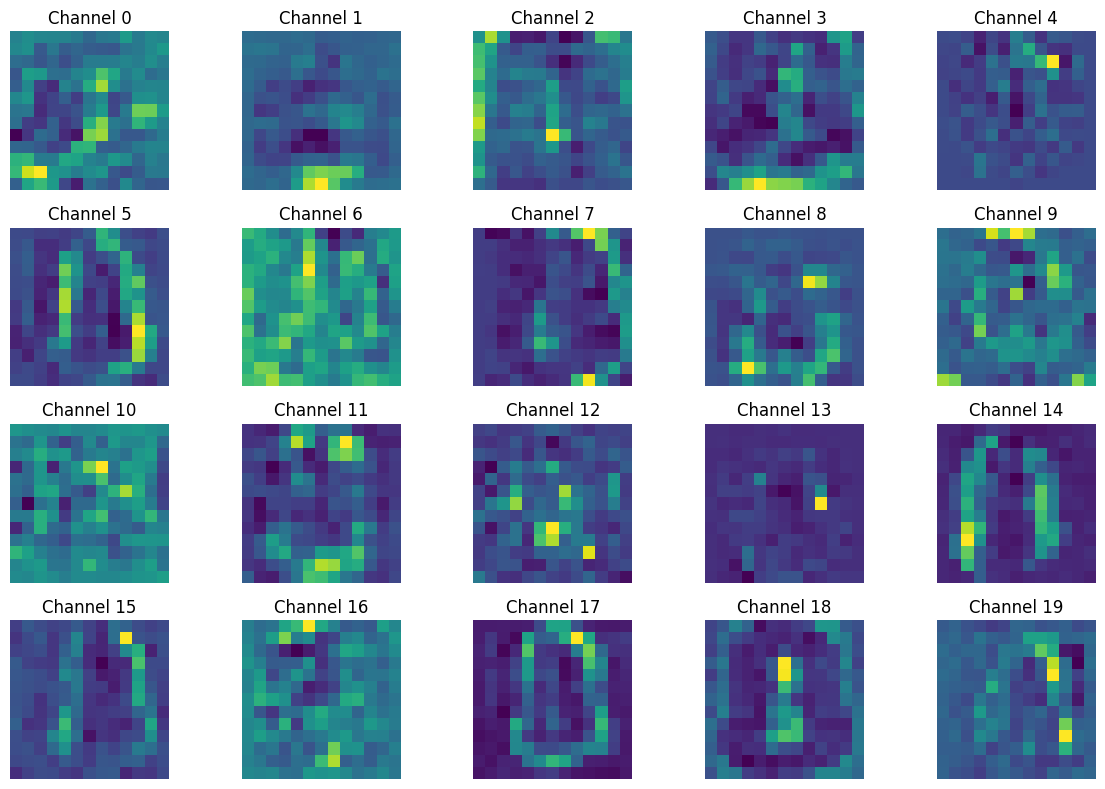

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a assumed shape: (577*1024,) or already (577,1024)
a_f = np.reshape(a, layer_shape)  # if needed

n_channels = 20
ncols = 5
nrows = int(np.ceil(n_channels / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))
axes = axes.flatten()

for c in range(n_channels):
    if "vit" in cfg.model_name:
        patch_acts = a_f[1:, c]          # drop CLS token → (576,)
        H = W = int(np.sqrt(patch_acts.shape[0]))  # 24
        patch_map = patch_acts.reshape(H, W)
    else:
        patch_map = a_f[c+100,:,:]
        

    im = axes[c].imshow(patch_map, cmap="viridis")
    axes[c].set_title(f"Channel {c}")
    axes[c].axis("off")

# remove unused axes
for ax in axes[n_channels:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [294]:
from torchvision import models, datasets 
from torch.utils.data import DataLoader

dataset = ImageFolder(
    root=f"{paths['livingstone_lab']}/Stimuli/fewer_occlusion/",
    transform=transform,
    is_valid_file=lambda x: not x.endswith("Thumbs.db"), 
    allow_empty=True, 
)
#mapping_idx = map_image_order_from_ann_to_monkey(paths, cfg.monkey_name, cfg.date, dataset)
# dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)



Text(0.5, 1.0, '206')

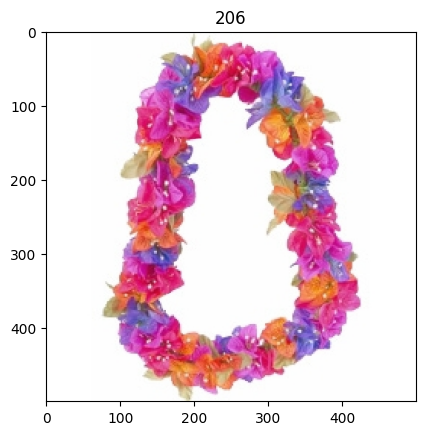

In [295]:
# os.path.basename(path) for path, _ in dataset.samples
img_path, img_title = dataset.samples[mapping_idx[curr_img]]
from PIL import Image
img = Image.open(img_path)
plt.imshow(img)
plt.title(img_title)

In [213]:
allimgs_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_allimages{cfg.date}.mat"
with h5py.File(allimgs_path, "r") as f:
    try:
        refs = f["allimages"][:]      # shape (N, 1) of object refs
    except KeyError:
        refs = f["uniqueImage"][:]
    # end try
    image_names = decode_matlab_strings(f, refs)
    image_names = list(dict.fromkeys(image_names)) 
# from scipy.io import loadmat
# loadmat(allimgs_path)

In [368]:

a = loadmat("/Volumes/LivingstoneLab/will/analysis/dynamic_RSA/vit_large_patch16_384/P_CIT-Pa230204_0308_Z4Sb.mat")


dict_keys(['__header__', '__version__', '__globals__', 'model', 'layers', 'time_bins', 'rsa', 'neur_names'])
99


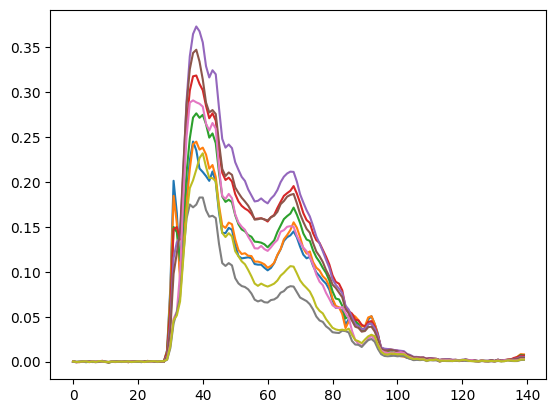

In [383]:
print(a.keys())
print(len(a['neur_names'][0]))
fig, ax = plt.subplots()
ax.plot(a['rsa'][:,:].T)